<img src="elkh_logo.svg" style="height: 51px; margin-right: 40px;" /> <img src="julich_logo.png" />

# About

This demo notebook shows how to compute the "EV Charger Placement" problem on a virtual machine started in the ELKH Cloud using a simulator, and how to compute the same problem using D-Wave's binary quadratic model (BQM) hybrid solver, using an actual quantum hardware.

The demo builds on the example from the D-Wave example repository <a href="https://github.com/dwave-examples/ev-charger-placement">ev-charger-placement</a>, with some minor modifications.

# Prerequsites

## Packages

First, we need to import some packages, including functions for generating the map, and SDK for accessing D-Wave hardware as well.

In [1]:
# Import necessary packages
import demo
import demo_numpy
import neal
from dwave.system import LeapHybridSampler

## Parameters
These are parameters for the execution:
* `width`: the width of the map,
* `height`: the height of the map,
* `num_pois`: the number of points of interests (PoI),
* `num_chargers`: the number of existing chargers,
* `num_new_chargers`: the number of new chargers to place.

In [2]:
# Parameters for the execution
width = 75
height = 75
num_pois = 30
num_chargers = 10
num_new_chargers = 10

## API access token
In order to use D-Wave services, the API token needs to be set. Please update the code below to include your API token. You can find it through the <a targer="_blank" href="https://cloud.dwavesys.com/leap/">D-Wave Leap Dashboard</a>.

<b><span style="color:red">PLEASE CHANGE THE VALUE BELOW!</span></b>

In [3]:
API_TOKEN="XXX"

# Build graph
First we build the grid graph of a random city. This includes setting up the grid with the required width and height, and placing the PoIs and existing charging stations in a random manner.

In [4]:
G, pois, charging_stations, potential_new_cs_nodes = demo.set_up_scenario(width, 
                                                                            height, 
                                                                            num_pois, 
                                                                            num_chargers)


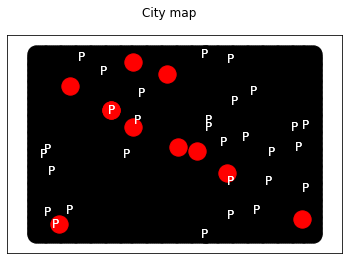

In [5]:
demo.save_output_image("map_start.png", "City map", G, pois, charging_stations, [])

# Build BQM

After the graph is ready, we can build a Binary Quadratic Model based on it. There are four constraints included in the model, as described in the example's repository, <a href="https://github.com/dwave-examples/ev-charger-placement">ev-charger-placement</a>:
* Minimize distance to POIs,
* Maximize distance to existing charging stations,
* Maximize distance to other new charging stations,
* Choose exactly the required number of new charging locations.

In [6]:
bqm = demo_numpy.build_bqm(potential_new_cs_nodes,
                            num_pois,
                            pois,
                            num_chargers,
                            charging_stations,
                            num_new_chargers)
print('Finished building Binary Quadratic Model');

Finished building Binary Quadratic Model


# Run computation using simulator

First we can run the computation "locally", on the virtual machine started in the ELKH Cloud. For this, the simulated annealing sampler is used.

In [7]:
sampler = neal.SimulatedAnnealingSampler()

Calculation took 24.046878 seconds

Solution returned: 
------------------

New charging locations:				 [(36, 61), (35, 22), (62, 17), (71, 10), (8, 24), (22, 45), (50, 9), (29, 18), (11, 58), (6, 13)]
Average distance to POIs:			 [48.333333333333336, 43.33333333333334, 49.399999999999984, 60.33333333333335, 53.400000000000006, 43.4, 49.26666666666666, 46.73333333333333, 55.400000000000006, 60.73333333333334]
Average distance to old charging stations:	 [78.0, 38.0, 60.0, 62.0, 15.0, 48.0, 42.0, 28.0, 50.0, 6.0]
Distance between new chargers:			 2195


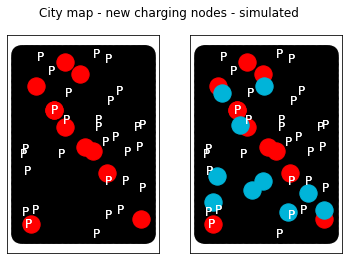

In [8]:
new_charging_nodes = demo.run_bqm_and_collect_solutions(bqm, sampler, potential_new_cs_nodes)
demo.printout_solution_to_cmdline(pois, num_pois, charging_stations, num_chargers, new_charging_nodes, num_new_chargers)
demo.save_output_image("map_simulated.png", "City map - new charging nodes - simulated", G, pois, charging_stations, new_charging_nodes)

# Run computation using D-Wave Hybrid Sampler

After we have received some valid results using the simulator, it is time to run the code on real quantum hardware. The `LeapHybridSampler` enables the usage of the D-Wave hardware.

Calculation took 666.731679 seconds

Solution returned: 
------------------

New charging locations:				 [(63, 64), (9, 17), (2, 31), (28, 68), (63, 29), (14, 73), (71, 4), (71, 46), (8, 66), (8, 4)]
Average distance to POIs:			 [54.66666666666666, 56.33333333333334, 55.4, 55.13333333333334, 44.666666666666664, 65.13333333333333, 65.33333333333333, 50.266666666666666, 63.066666666666656, 66.2]
Average distance to old charging stations:	 [108.0, 7.0, 28.0, 77.0, 73.0, 68.0, 68.0, 98.0, 57.0, 7.0]
Distance between new chargers:			 2947


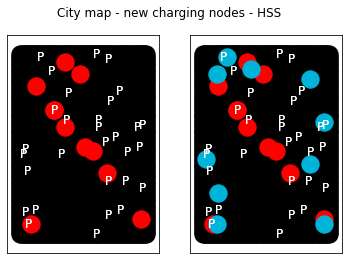

In [9]:
h_sampler = LeapHybridSampler(token=API_TOKEN)
h_new_charging_nodes = demo.run_bqm_and_collect_solutions(bqm, h_sampler, potential_new_cs_nodes)
demo.printout_solution_to_cmdline(pois, num_pois, charging_stations, num_chargers, h_new_charging_nodes, num_new_chargers)
demo.save_output_image("map_hss.png", "City map - new charging nodes - HSS", G, pois, charging_stations, h_new_charging_nodes)